<a href="https://colab.research.google.com/github/sabeesh90/Imputation_vs_Augmentation_Facial_Key_Point_Detection/blob/main/FKPD_With_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Keypoints Detection
In this project will build model to detect the 15 facial keypoints (x,y co-ordinates) for a given facial image.

In [ ]:
import numpy as np
import pandas as pd

import os
#from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from math import sin, cos, pi
import cv2

import tensorflow as tf
import keras

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis

In [ ]:
# Mount drive on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read input files from path

train_path = "/content/drive/My Drive/fkd_dataset/training.csv"
test_path = "/content/drive/My Drive/fkd_dataset/test.csv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

#train = pd.read_csv("/kaggle/input/training/training.csv")

In [ ]:
train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [ ]:
#observe the different feature type present in the data

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [ ]:
# Check for missing data

train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
# Discard the images/rows with missing values
train_15kp_data = train_data.dropna().reset_index()

In [ ]:
train_15kp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      2140 non-null   int64  
 1   left_eye_center_x          2140 non-null   float64
 2   left_eye_center_y          2140 non-null   float64
 3   right_eye_center_x         2140 non-null   float64
 4   right_eye_center_y         2140 non-null   float64
 5   left_eye_inner_corner_x    2140 non-null   float64
 6   left_eye_inner_corner_y    2140 non-null   float64
 7   left_eye_outer_corner_x    2140 non-null   float64
 8   left_eye_outer_corner_y    2140 non-null   float64
 9   right_eye_inner_corner_x   2140 non-null   float64
 10  right_eye_inner_corner_y   2140 non-null   float64
 11  right_eye_outer_corner_x   2140 non-null   float64
 12  right_eye_outer_corner_y   2140 non-null   float64
 13  left_eyebrow_inner_end_x   2140 non-null   float

So, we have only 2140 images with 15 keypoints for training.

#3. Data Imputation

In [ ]:
# impute missing data with ffill
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
train_4kp_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape: {}\n".format(np.shape(train_4kp_data)))

unclean_train_data shape: (7049, 31)



In [ ]:
train_4kp_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


##Data Set Flag definition

In [ ]:
Flag_include_unclean_data = True    # Whether to include samples with missing keypoint values. Note that the missing values would however be filled using Pandas' 'ffill' later.

In [ ]:
# User Defined Functions
# To convert the image data from string to Array
def string_to_array(pd_series):
    '''
    pd_series: a pandas series, contains img pixels as strings,
    each element is a long str (length = 96*96 = 9216),
    contains pixel values. eg:('29 34 122 244 12 ....').
    
    1- Convert str of pixel values to 2d array.
    2- Stack all arrays into one 3d array.
    
    returns 3d numpy array of shape of (num of images, 96, 96, 1).
    '''
    data_size = len(pd_series)
    #intialize output 3d array as numpy zeros array.
    X = np.zeros(shape=(data_size,96,96,1), dtype=np.float32)
    for i in tqdm(range(data_size)):
        img_str = pd_series[i]
        img_list = img_str.split(' ')
        img_array = np.array(img_list, dtype=np.float32)
        img_array = img_array.reshape(96,96,1)
        X[i] = img_array
    return X

# Function to plot Facial image with Keypoints
def display_faceimg_with_kps(fimg, kps):
    plt.imshow(fimg[:,:,0], cmap='gray')
    for i in range(1,31,2):
        plt.plot(kps[i-1], kps[i], 'g.')

def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

In [ ]:
# split labels into y_train
X_train_15kp = string_to_array(train_15kp_data['Image'])
labels_15kp =  train_15kp_data.drop(['index','Image'], axis=1)
y_train_15kp = labels_15kp.to_numpy(dtype=np.float32)
print('\nX_train 15kp shape : ', X_train_15kp.shape)
print('y_train 15kp shape: ', y_train_15kp.shape)

X_train = X_train_15kp
y_train = y_train_15kp

## for missing data
X_train_4kp = string_to_array(train_4kp_data['Image'])
labels_4kp =  train_4kp_data.drop(['Image'], axis=1)
y_train_4kp = labels_4kp.to_numpy(dtype=np.float32)
print('\nX_train 4kp shape : ', X_train_4kp.shape)
print('y_train 4kp shape: ', y_train_4kp.shape)

  1%|          | 69/7049 [00:00<00:10, 686.79it/s]


X_train 15kp shape :  (2140, 96, 96, 1)
y_train 15kp shape:  (2140, 30)


100%|██████████| 7049/7049 [00:10<00:00, 665.10it/s]


X_train 4kp shape :  (7049, 96, 96, 1)
y_train 4kp shape:  (7049, 30)


In [ ]:
y_train_15kp.shape

(2140, 30)

In [ ]:
y_train_4kp.shape

(7049, 30)

In [ ]:
if Flag_include_unclean_data:
  # Concatenate 15kp data with the imputed 4kp data, to form the final dataset
  X_train = np.concatenate((X_train, X_train_4kp))
  y_train = np.concatenate((y_train, y_train_4kp))
  print('\nX_train shape : ', X_train.shape)
  print('y_train shape: ', y_train.shape)


X_train shape :  (9189, 96, 96, 1)
y_train shape:  (9189, 30)


In [ ]:
X_train = X_train/255.0

In [ ]:
y_train = (y_train - 48.)/48.

In [ ]:
print(X_train)

[[[[0.93333334]
   [0.9254902 ]
   [0.92941177]
   ...
   [0.98039216]
   [0.98039216]
   [0.98039216]]

  [[0.92156863]
   [0.93333334]
   [0.9254902 ]
   ...
   [0.9764706 ]
   [0.98039216]
   [0.9843137 ]]

  [[0.92941177]
   [0.9254902 ]
   [0.92941177]
   ...
   [0.9843137 ]
   [0.9843137 ]
   [0.98039216]]

  ...

  [[0.7294118 ]
   [0.7176471 ]
   [0.70980394]
   ...
   [0.20392157]
   [0.22352941]
   [0.23529412]]

  [[0.7411765 ]
   [0.7372549 ]
   [0.8117647 ]
   ...
   [0.23921569]
   [0.27058825]
   [0.30588236]]

  [[0.7490196 ]
   [0.72156864]
   [0.72156864]
   ...
   [0.27450982]
   [0.29411766]
   [0.3529412 ]]]


 [[[0.85882354]
   [0.84313726]
   [0.8       ]
   ...
   [0.36078432]
   [0.34509805]
   [0.32941177]]

  [[0.87058824]
   [0.85882354]
   [0.8627451 ]
   ...
   [0.36078432]
   [0.34509805]
   [0.3372549 ]]

  [[0.90588236]
   [0.8784314 ]
   [0.83137256]
   ...
   [0.3019608 ]
   [0.3137255 ]
   [0.32941177]]

  ...

  [[0.00392157]
   [0.00392157]
   [0.0

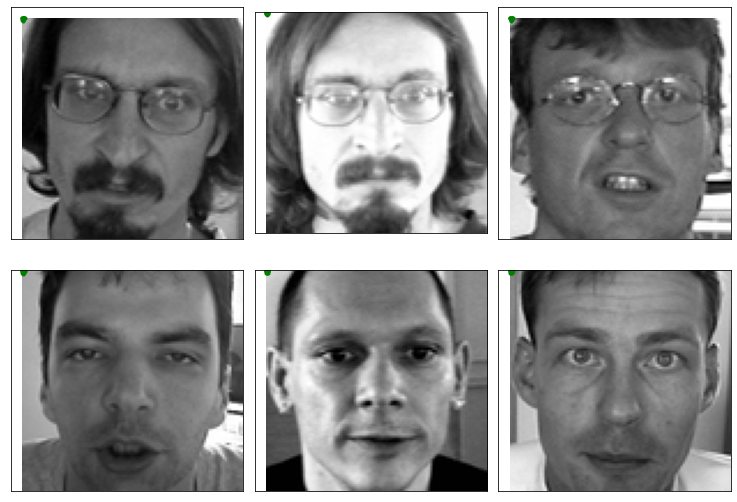

In [ ]:
#Function to display face images with KPs.
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
import random
r = random.randint(1,2133)
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    r = r+i
    display_faceimg_with_kps(X_train[r], y_train[r])

plt.show()

#3. DATA AUGMENTATION

In [ ]:
flag_horizontal_flip = False
flag_rotation_augmentation = True
flag_brightness_augmentation = True
flag_shift_augmentation = True
flag_random_noise_augmentation = True

sample_image_index = 20    # Index of sample train image used for visualizing various augmentations

rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

NUM_EPOCHS = 75
BATCH_SIZE = 128

### 3.1 Horizontal Flip


In [ ]:
# Reference : https://www.kaggle.com/balraj98/data-augmentation-for-facial-keypoint-detection
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if flag_horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(X_train_15kp, y_train_15kp)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    X_train = np.concatenate((X_train, flipped_train_images))
    y_train = np.concatenate((y_train, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 


### 3.2 Rotation Augmentation

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



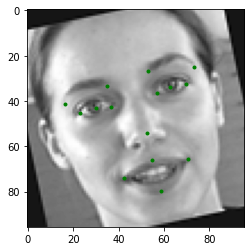

In [ ]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if flag_rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(X_train_15kp, y_train_15kp)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    X_train = np.concatenate((X_train, rotated_train_images))
    y_train = np.concatenate((y_train, rotated_train_keypoints))
    fig, axis = plt.subplots()
    display_faceimg_with_kps(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index])
    #plot_sample(, axis, "Rotation Augmentation")

### 3.3 Brightness Alteration

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


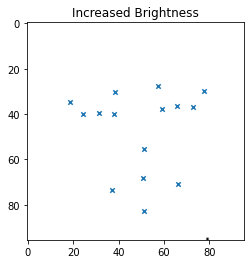

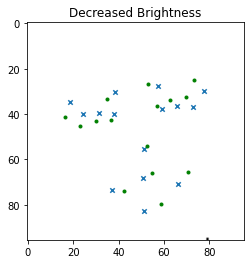

In [ ]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if flag_brightness_augmentation:
  altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(X_train_15kp, y_train_15kp)
  print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
  print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
  X_train = np.concatenate((X_train, altered_brightness_train_images))
  y_train = np.concatenate((y_train, altered_brightness_train_keypoints))
  fig, axis = plt.subplots()
  plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
  fig, axis = plt.subplots()
  display_faceimg_with_kps(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index])
  plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness") 


### 3.4 Horizontal and Vertical Shift

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


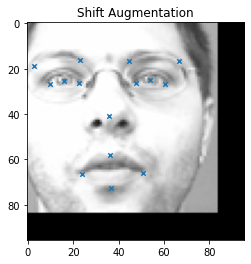

In [ ]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if flag_shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(X_train_15kp, y_train_15kp)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    X_train = np.concatenate((X_train, shifted_train_images))
    y_train = np.concatenate((y_train, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

### 3.5 Random Noise Augmentation

Shape of noisy_train_images: (2140, 96, 96, 1)


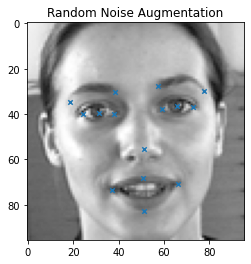

In [ ]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1),dtype=cv2.CV_32F)    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if flag_random_noise_augmentation:
    noisy_train_images = add_noise(X_train_15kp)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    X_train = np.concatenate((X_train, noisy_train_images))
    y_train = np.concatenate((y_train, y_train_15kp))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], y_train_15kp[sample_image_index], axis, "Random Noise Augmentation")

### Visualize train images after augmentation

Shape of final train_images: (26239, 96, 96, 1)
Shape of final train_keypoints: (26239, 30)

 Clean Train Data: 


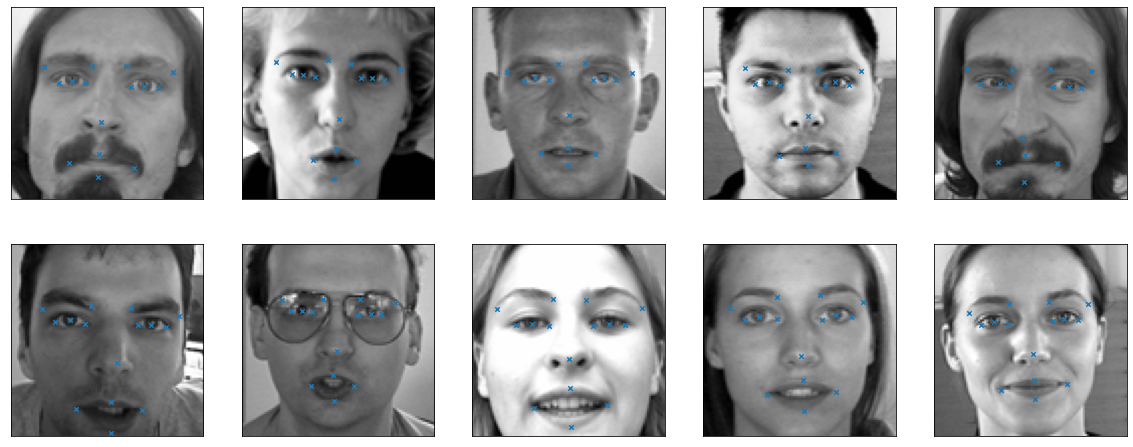

Unclean Train Data: 


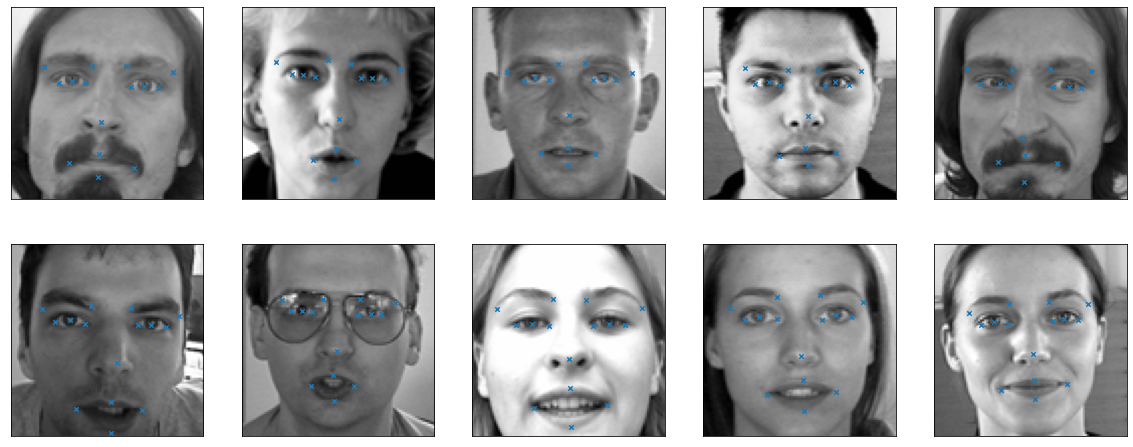

Rotation Augmentation: 


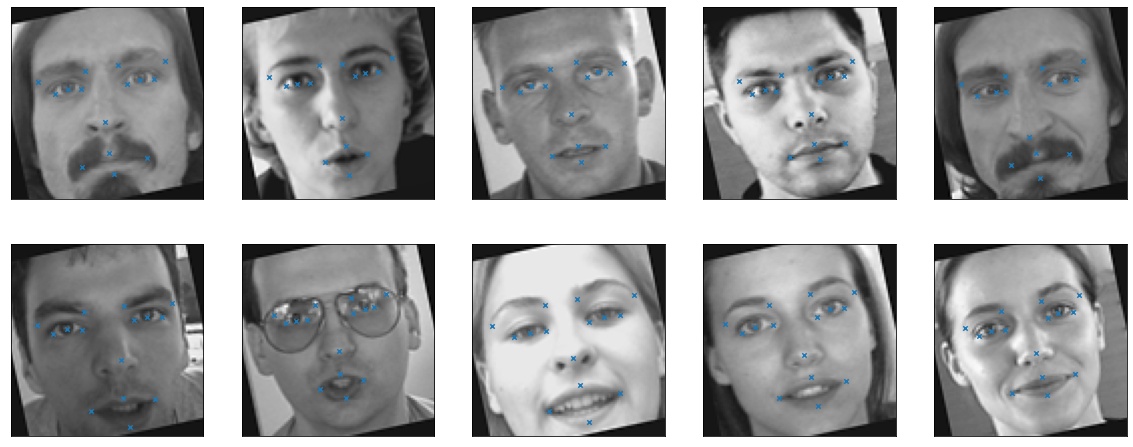

Brightness Augmentation: 


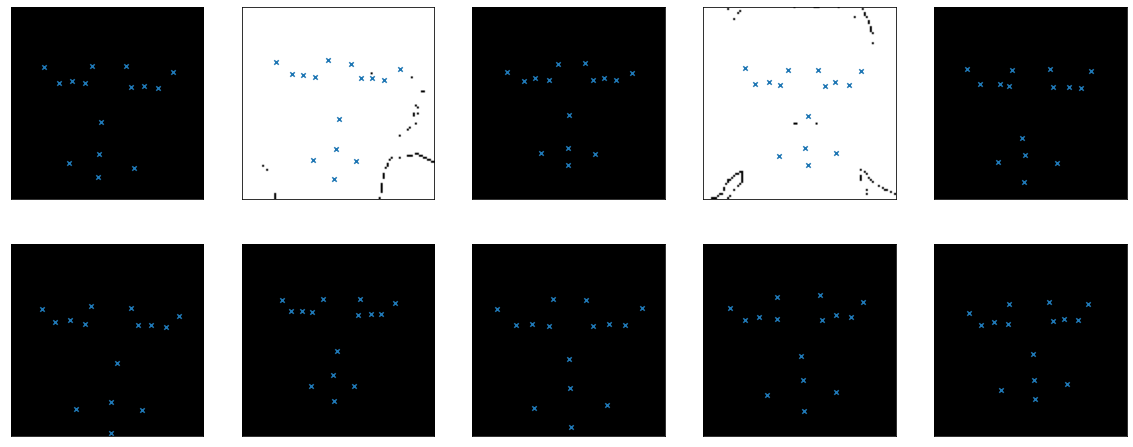

Shift Augmentation: 


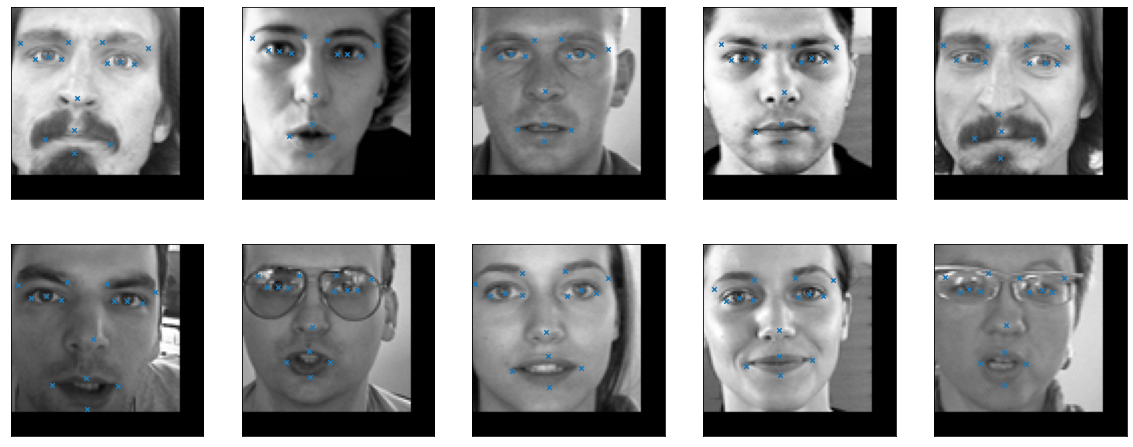

Random Noise Augmentation: 


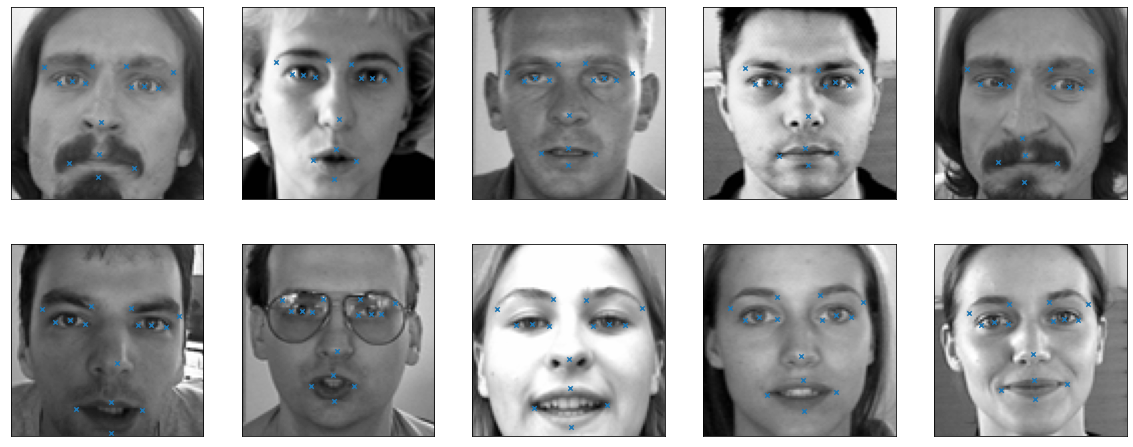

In [ ]:
print("Shape of final train_images: {}".format(np.shape(X_train)))
print("Shape of final train_keypoints: {}".format(np.shape(y_train)))

print("\n Clean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(X_train_15kp[i], y_train_15kp[i], axis, "")
plt.show()

if Flag_include_unclean_data:
    print("Unclean Train Data: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(X_train_4kp[i], y_train_4kp[i], axis, "")
    plt.show()

if flag_horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if flag_rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if flag_brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if flag_shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if flag_random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], y_train_15kp[i], axis, "")
    plt.show()

# Model 1 : Simple CNN_PrathiNet

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [ ]:
model_p1 = Sequential()

model_p1.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())

model_p1.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())
model_p1.add(MaxPool2D(pool_size=(2, 2)))

model_p1.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())

model_p1.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())
model_p1.add(MaxPool2D(pool_size=(2, 2)))

model_p1.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())

model_p1.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())
model_p1.add(MaxPool2D(pool_size=(2, 2)))

model_p1.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())

model_p1.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())
model_p1.add(MaxPool2D(pool_size=(2, 2)))

model_p1.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())

model_p1.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model_p1.add(LeakyReLU(alpha = 0.1))
model_p1.add(BatchNormalization())


model_p1.add(Flatten())
model_p1.add(Dense(512,activation='relu'))
model_p1.add(Dropout(0.1))
model_p1.add(Dense(30))
model_p1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

In [ ]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

#model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
#          metrics =["accuracy"])

model_p1.compile(optimizer = 'adam',loss = root_mean_squared_error, metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'),'acc'])
model_p1.fit(X_train,y_train,batch_size=256, epochs=1)

103/103 [==============================] - 17s 165ms/step - loss: 11.5051 - rmse: 19.5324 - acc: 0.2998


In [ ]:
# Evaluate on Test Data

# Model 2 : Transfer Learning using Res NET

In [ ]:
from keras.applications import ResNet50
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [ ]:
resnet = ResNet50(weights='imagenet',include_top= False) 

input_tensor = Input(shape=(96,96,1) )
x = Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
last_layer = resnet (x)
x1 = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x1 = Dense(512, activation='relu',name='fc-1')(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(256, activation='relu',name='fc-2')(x1)
x1 = Dropout(0.5)(x1)
# a softmax layer for 4 classes
out = Dense(30, activation='softmax',name='output_layer')(x1) 

custom_resnet_model = Model(inputs=input_tensor,outputs=out)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
custom_resnet_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 3)         30        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
fc-1 (Dense)                 (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc-2 (Dense)                 (None, 256)              

In [ ]:
for layer in custom_resnet_model.layers[:-6]:
	layer.trainable = False

In [ ]:
custom_resnet_model.layers[-1].trainable

True

In [ ]:
custom_resnet_model.compile(optimizer = 'adam',loss = root_mean_squared_error, metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'),'acc'])

In [ ]:
#import time
#t=time.time()
#hist = custom_resnet_model.fit(X_train, y_train, batch_size=256, epochs=50, verbose=1)
#print('Training time: %s' % (t - time.time()))

In [ ]:
# Model Evaluation

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import GlobalAveragePooling2D, Dense, Dropout


In [ ]:
mobnetv2 = MobileNetV2(weights='imagenet',include_top= False) 
input_tensor = Input(shape=(96,96,1) )
x = Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
last_layer = mobnetv2 (x)
x1 = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x1 = Dense(512, activation='sigmoid',name='fc-1')(x1)
#x1 = Dropout(0.5)(x1)
#x1 = Dense(256, activation='relu',name='fc-2')(x1)
#x1 = Dropout(0.5)(x1)
# a softmax layer for 4 classes
out = Dense(30, activation='softmax',name='output_layer')(x1) 

custom_mobnet_model = Model(inputs=input_tensor,outputs=out)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
custom_mobnet_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 96, 3)         30        
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
fc-1 (Dense)                 (None, 512)               655872    
_________________________________________________________________
output_layer (Dense)         (None, 30)                15390     
Total params: 2,929,276
Trainable params: 2,895,164
Non-trainable params: 34,112
_______________________________________

In [ ]:
for layer in custom_mobnet_model.layers[:-6]:
	layer.trainable = False


In [ ]:
custom_mobnet_model.layers[-1].trainable

True

In [ ]:
custom_mobnet_model.compile(optimizer = 'adam',loss = root_mean_squared_error, metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'),'acc'])

In [ ]:
import time
t=time.time()
hist = custom_mobnet_model.fit(X_train, y_train, batch_size=256, epochs=40, verbose=1)
print('Training time: %s' % (t - time.time()))

Epoch 1/40
103/103 [==============================] - 22s 211ms/step - loss: 33.1760 - rmse: 41.1954 - acc: 0.6065
Epoch 2/40
103/103 [==============================] - 21s 208ms/step - loss: 33.1744 - rmse: 41.1943 - acc: 0.7351
Epoch 3/40
103/103 [==============================] - 22s 209ms/step - loss: 33.1743 - rmse: 41.1943 - acc: 0.7497
Epoch 4/40
103/103 [==============================] - 21s 208ms/step - loss: 33.1742 - rmse: 41.1942 - acc: 0.7636
Epoch 5/40
103/103 [==============================] - 22s 209ms/step - loss: 33.1742 - rmse: 41.1942 - acc: 0.7645
Epoch 6/40
103/103 [==============================] - 21s 208ms/step - loss: 33.1742 - rmse: 41.1942 - acc: 0.7777
Epoch 7/40
103/103 [==============================] - 21s 208ms/step - loss: 33.1742 - rmse: 41.1942 - acc: 0.7856
Epoch 8/40
103/103 [==============================] - 22s 209ms/step - loss: 33.1742 - rmse: 41.1942 - acc: 0.7841
Epoch 9/40
103/103 [==============================] - 22s 209ms/step - loss: 33.

In [ ]:
# Model Evaluation